<a href="https://colab.research.google.com/github/fawasafsal/Brain-Tumour-MRI-Image-Classification/blob/main/Brain_Tumour_MRI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

In [ ]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/MRI_Dataset.zip'
extraction_path = 'data/extracted_files'

# Check if the extraction path exists, if not, create it
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

extracted_files = os.listdir(extraction_path)
extracted_files


['Data']

In [ ]:
# Define paths
source_folder = os.path.join('data', 'extracted_files', 'Data')
target_folder = 'Brain_tumor_dataset'

# Check if the source folder exists
if not os.path.exists(source_folder):
    print(f"Source folder not found: {source_folder}")
    raise FileNotFoundError(f"Source folder not found: {source_folder}")

In [ ]:
# Define labels and their mapped names
labels = ['Normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
mapped_labels = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Create target folders for training and testing
for phase in ['training', 'testing']:
    for label in mapped_labels:
        os.makedirs(os.path.join(target_folder, phase, label), exist_ok=True)


In [ ]:
# Function to copy images to the new folder structure
def copy_images_to_folder(image_paths, destination_folder):
    for img_path in image_paths:
        label = os.path.basename(os.path.dirname(img_path))
        if label == 'Normal':
            label = 'no_tumor'  # Rename 'Normal' to 'no_tumor' for consistency
        dest_path = os.path.join(destination_folder, label, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

# Function to load and sample images
def load_and_sample_images(folder_path, label, target_label):
    image_list = []
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid image files
                image_list.append(os.path.join(folder_path, filename))

        # Randomly sample a portion of the images
        sampled_images = random.sample(image_list, len(image_list) // 5)
        return [(img_path, target_label) for img_path in sampled_images]
    else:
        print(f"Folder not found: {folder_path}")
        return []

In [ ]:
import random
# Collect and sample images
all_images_and_labels = []
all_images_and_labels.extend(load_and_sample_images(os.path.join(source_folder, 'Normal'), 'Normal', 'no_tumor'))

for label in ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']:
    all_images_and_labels.extend(load_and_sample_images(os.path.join(source_folder, 'Tumor', label), label, label))

# Separate images and labels
all_images = [item[0] for item in all_images_and_labels]
all_labels = [item[1] for item in all_images_and_labels]

In [ ]:
import shutil
# Split data into training (60%) and testing (40%) sets
train_images, test_images, _, _ = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)

# Copy images to respective training and testing folders
copy_images_to_folder(train_images, os.path.join(target_folder, 'training'))
copy_images_to_folder(test_images, os.path.join(target_folder, 'testing'))

print("Data split and copied successfully!")

Data split and copied successfully!


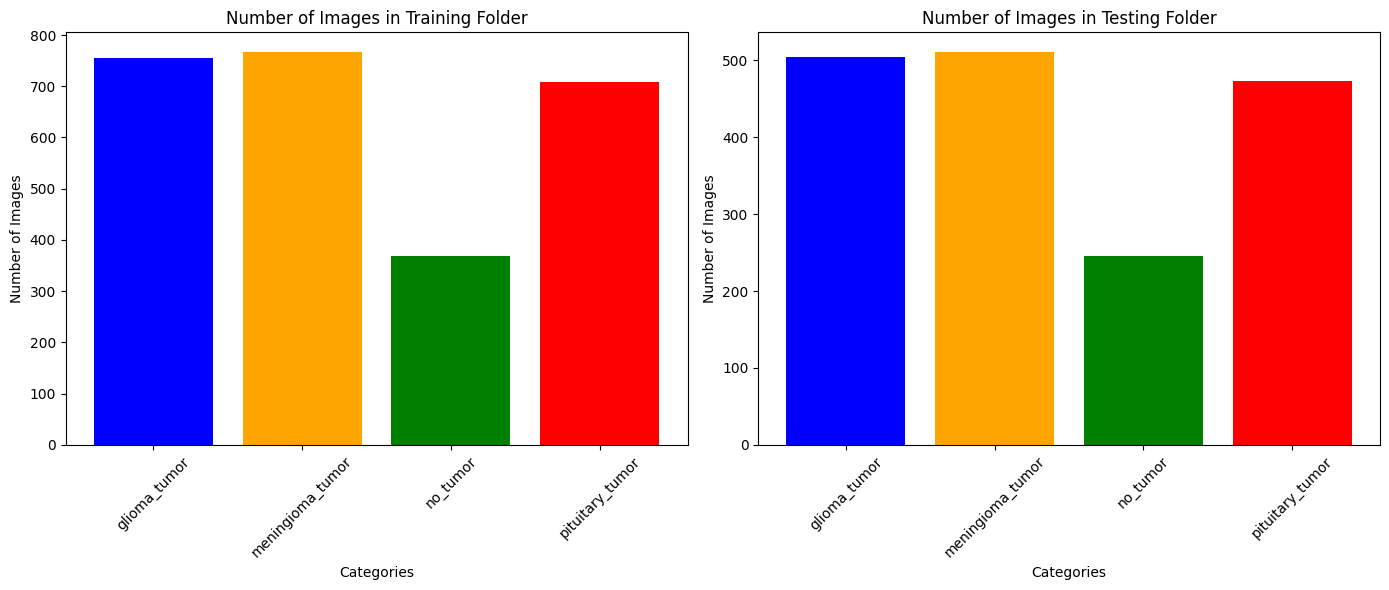

In [ ]:
# Define paths for the training and testing directories
base_dir = 'Brain_tumor_dataset'
subdirs = ['training', 'testing']
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Function to count the number of images in each subdirectory
def count_images_in_folders(base_path, labels):
    counts = {}
    for label in labels:
        folder_path = os.path.join(base_path, label)
        if os.path.exists(folder_path):
            counts[label] = len([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        else:
            counts[label] = 0
    return counts

# Count images for both training and testing folders
image_counts = {subdir: count_images_in_folders(os.path.join(base_dir, subdir), labels) for subdir in subdirs}
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, subdir in enumerate(subdirs):
    counts = image_counts[subdir]
    axes[i].bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(f'Number of Images in {subdir.capitalize()} Folder')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Number of Images')
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
#image loading, resizing, and labeling for both training and testing datasets.
x_train = [] # MRI image
y_train = [] # Label of the image
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


image_size = 256
for i in labels:
    folderPath = os.path.join('/content/Brain_tumor_dataset/training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Brain_tumor_dataset/testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x_train.append(img)
        y_train.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 473/473 [00:00<00:00, 1891.34it/s]


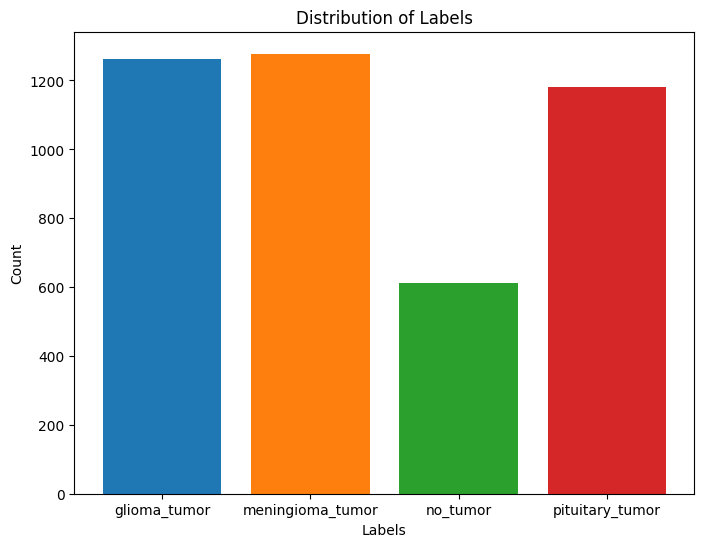

In [ ]:
#visualizes the distribution of different labels in the training dataset (y_train)
# Use a compressed for loop to create a object of the label and the count
label_counts = {label: np.sum(y_train == label) for label in labels}

# Stretch the graph
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

In [ ]:
# Convert the label to one-hot encoding format which converts the categorical data to numeric one
y_train = np.array(pd.get_dummies(y_train))

print(y_train)

[[ True False False False]
 [ True False False False]
 [ True False False False]
 ...
 [False False False  True]
 [False False False  True]
 [False False False  True]]


In [ ]:
#Split the dataset into training, testing and validation sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2,random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f'X_train shape: {(x_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(x_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_valid shape: {(x_valid).shape}\n'
      f'y_valid shape: {(y_valid).shape}')

X_train shape: (2772, 256, 256, 3)
y_train shape: (2772, 4)
X_test shape: (867, 256, 256, 3)
y_test shape: (867, 4)
X_valid shape: (694, 256, 256, 3)
y_valid shape: (694, 4)


In [ ]:
# Normalize pixel values of training images to the range [0,1]
x_train = x_train / 255

print(f"Maximum and Minimum pixel value after normalization: {x_train.min()} - {x_train.max()}")

Maximum and Minimum pixel value after normalization: 0.0 - 1.0


In [ ]:
x_test = x_test / 255

In [ ]:
x_valid = x_valid / 255

In [ ]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

# Hidden layer
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))

# Output layer
model.add(Dense(4, activation='softmax'))

# Model Config
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143,364 (8.18 MB)

 Trainable params: 2,143,364 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with a smaller batch size
start_time = time.time()

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=45,
    batch_size=32,
    verbose=1
)


Epoch 1/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.3637 - loss: 1.3423 - val_accuracy: 0.5418 - val_loss: 1.1421
Epoch 2/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5189 - loss: 1.0987 - val_accuracy: 0.5389 - val_loss: 1.0522
Epoch 3/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.5791 - loss: 0.9702 - val_accuracy: 0.6225 - val_loss: 0.8839
Epoch 4/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6479 - loss: 0.8509 - val_accuracy: 0.6988 - val_loss: 0.7885
Epoch 5/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6852 - loss: 0.7300 - val_accuracy: 0.6830 - val_loss: 0.7628
Epoch 6/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7172 - loss: 0.6892 - val_accuracy: 0.7464 - val_loss: 0.6569
Epoch 7/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7662 - loss: 0.5730 - val_accuracy: 0.7536 - val_loss: 0.6396
Epoch 8/45
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8012 - loss: 0.5048 - val_accuracy: 0.7536 - v

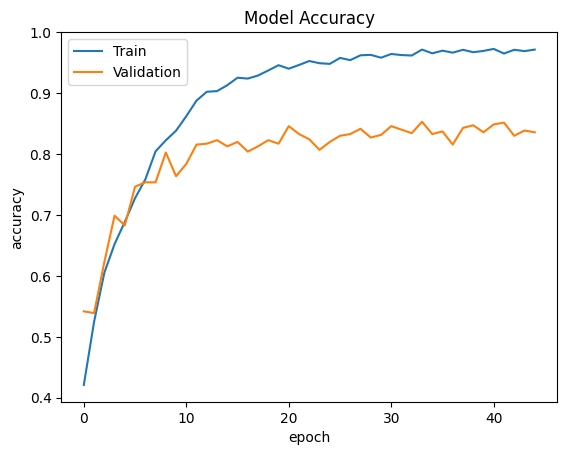

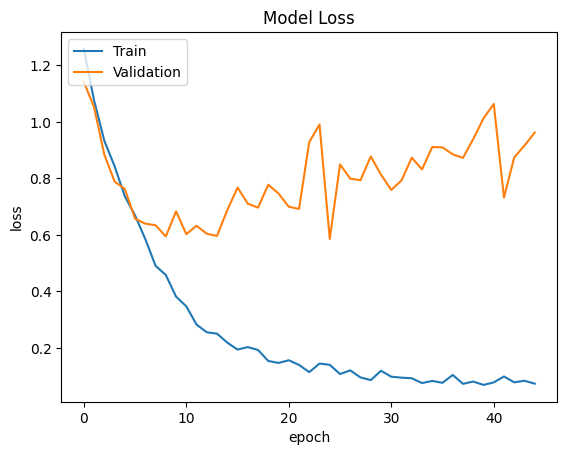

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step


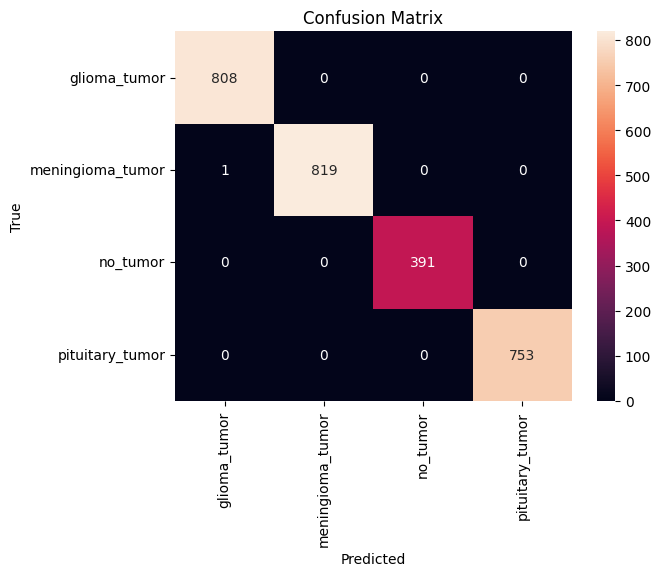

In [ ]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step


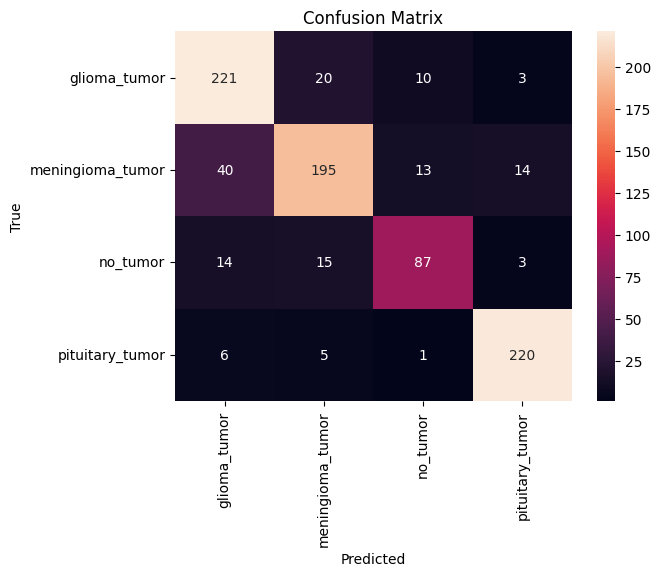

In [ ]:

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.79      0.87      0.83       254
meningioma_tumor       0.83      0.74      0.78       262
        no_tumor       0.78      0.73      0.76       119
 pituitary_tumor       0.92      0.95      0.93       232

        accuracy                           0.83       867
       macro avg       0.83      0.82      0.82       867
    weighted avg       0.83      0.83      0.83       867



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



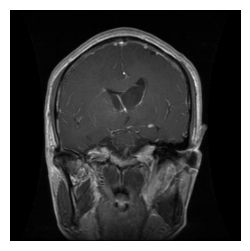

In [ ]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



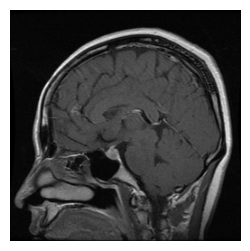

In [ ]:
img_path = '/content/data/extracted_files/Data/Tumor/pituitary_tumor/P_100.jpg'
custom_actual_label = 'pituitary_tumor'

custom_img_arr = []
tumor_img = cv2.imread(img_path)
tumor_img = cv2.resize(tumor_img, (256, 256))
custom_img_arr.append(tumor_img)
custom_img_arr = np.array(custom_img_arr)
custom_img_arr = custom_img_arr / 255

custom_pred = model.predict(custom_img_arr.reshape(1, 256, 256, 3))

custom_pred_class = np.argmax(custom_pred)
custom_pred_label = labels[custom_pred_class]
custom_pred_confidence = custom_pred[0][custom_pred_class]

print(f"Predicted label: {custom_pred_label} \nActual label: {custom_actual_label} \nConfidence: {custom_pred_confidence*100:.2f}%\n")
plt.figure(figsize=(3, 3))
plt.imshow(tumor_img)
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model2 = Sequential()

# Input layer
model2.add(Input(shape=(256, 256, 3)))

# Convolutional and Pooling layers with Batch Normalization
model2.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.2))

model2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.3))

model2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.4))

model2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D())
model2.add(Dropout(0.4))

# Fully connected layers
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Output layer
model2.add(Dense(4, activation='softmax'))

# Compile the model with a tuned learning rate
model2.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary
model2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 8,633,156 (32.93 MB)

 Trainable params: 8,631,940 (32.93 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:

start_time = time.time()

history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=45,
    batch_size=64,
    verbose=1
)

end_time = time.time()



Epoch 1/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.4960 - loss: 1.5361 - val_accuracy: 0.2867 - val_loss: 16.7245
Epoch 2/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.5818 - loss: 1.1238 - val_accuracy: 0.2867 - val_loss: 25.8247
Epoch 3/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.6489 - loss: 0.9631 - val_accuracy: 0.2867 - val_loss: 22.8664
Epoch 4/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.6724 - loss: 0.8620 - val_accuracy: 0.2867 - val_loss: 25.7069
Epoch 5/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.7079 - loss: 0.8133 - val_accuracy: 0.2867 - val_loss: 31.9940
Epoch 6/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7447 - loss: 0.6989 - val_accuracy: 0.3329 - val_loss: 17.6935
Epoch 7/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.7571 - loss: 0.6332 - val_accuracy: 0.4928 - val_loss: 8.1794
Epoch 8/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7768 - loss: 0.5906 - val_accuracy: 0.48

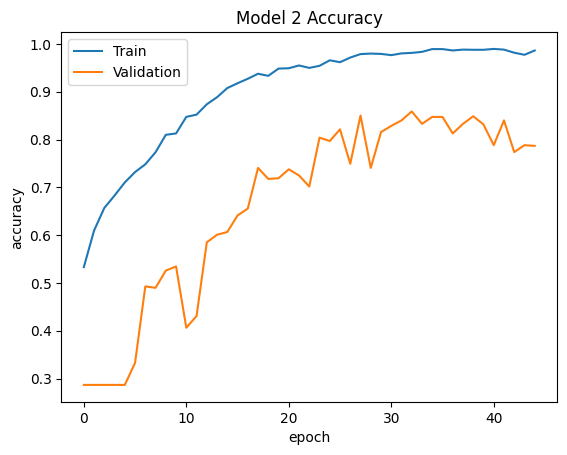

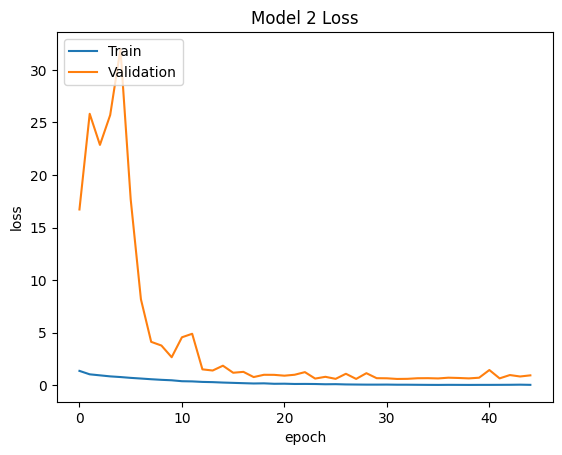

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step


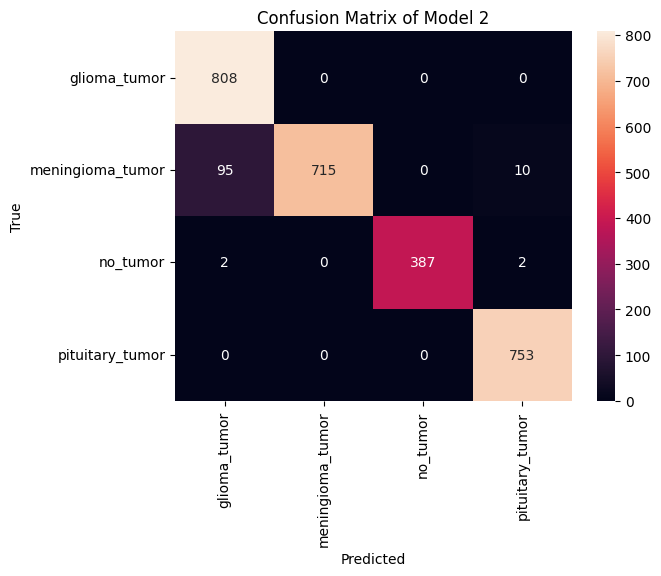

In [ ]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model2.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Model 2')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 478ms/step


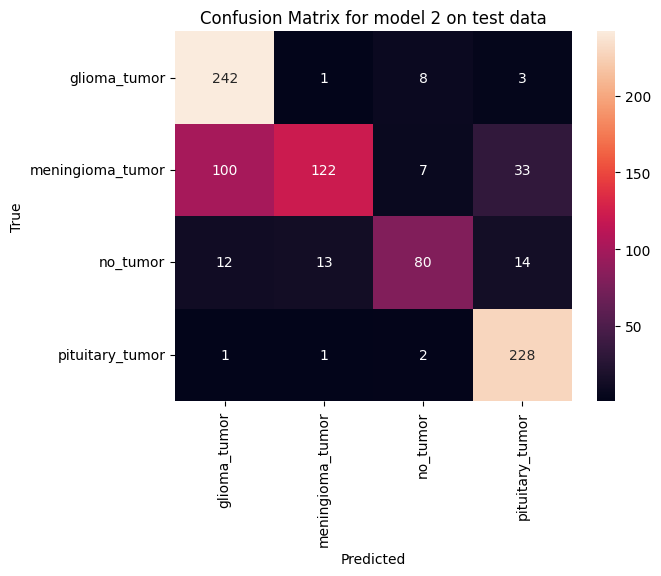

In [ ]:

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model2.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for model 2 on test data')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.68      0.95      0.79       254
meningioma_tumor       0.89      0.47      0.61       262
        no_tumor       0.82      0.67      0.74       119
 pituitary_tumor       0.82      0.98      0.89       232

        accuracy                           0.78       867
       macro avg       0.80      0.77      0.76       867
    weighted avg       0.80      0.78      0.76       867



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 99.99%



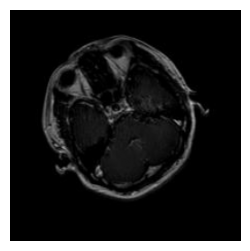

In [ ]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model2.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional base to avoid retraining it
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Build the model
model_resnet50 = Sequential([
    Input(shape=(256, 256, 3)),
    base_model_resnet50,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


# Display the model summary
model_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,143,428 (217.98 MB)

 Trainable params: 33,555,716 (128.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile the model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Fit the ResNet50 model
history_resnet50 = model_resnet50.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=25,
    batch_size=32,
    verbose=1
)


Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.3268 - loss: 2.5700 - val_accuracy: 0.4640 - val_loss: 1.2631
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.3275 - loss: 1.3234 - val_accuracy: 0.4409 - val_loss: 1.2872
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.3318 - loss: 1.2898 - val_accuracy: 0.5288 - val_loss: 1.2357
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.3578 - loss: 1.2583 - val_accuracy: 0.5634 - val_loss: 1.1705
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.4170 - loss: 1.2165 - val_accuracy: 0.5576 - val_loss: 1.1287
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.4242 - loss: 1.2067 - val_accuracy: 0.5648 - val_loss: 1.1252
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.4093 - loss: 1.1732 - val_accuracy: 0.5418 - val_loss: 1.0864
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.4285 - loss: 1.1791 - val_accuracy: 0.6066 - v

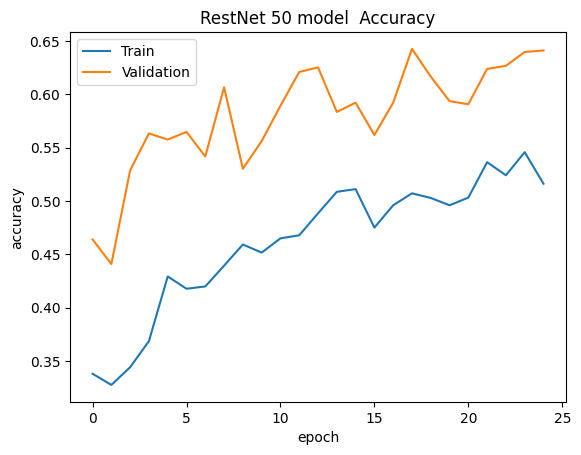

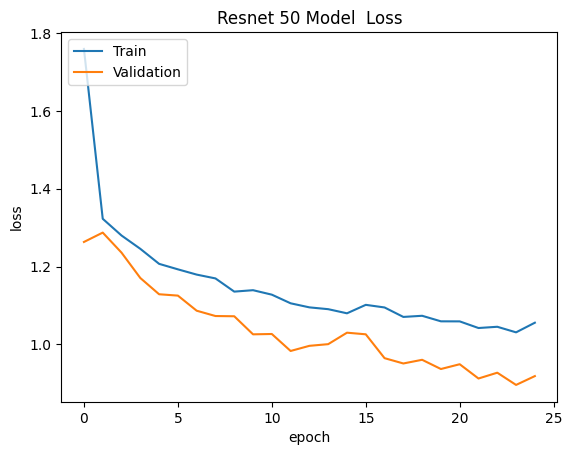

In [ ]:
# summarize history for accuracy
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('RestNet 50 model  Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Resnet 50 Model  Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step


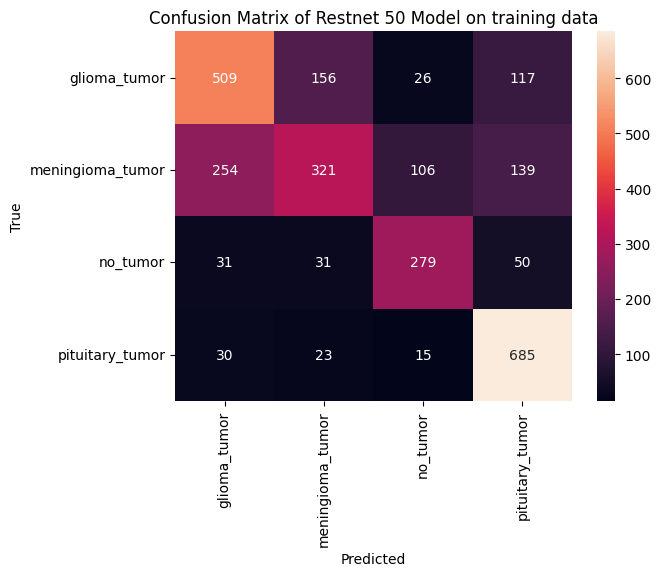

In [ ]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model_resnet50.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Restnet 50 Model on training data')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


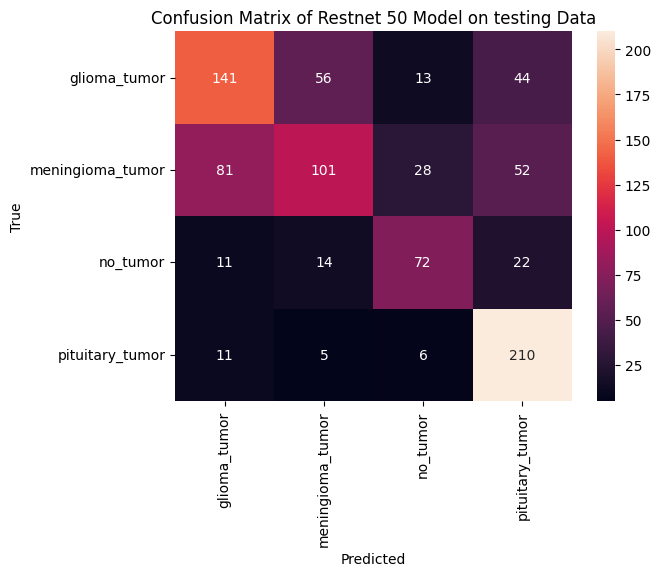

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model_resnet50.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix of Restnet 50 Model on testing Data")
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.58      0.56      0.57       254
meningioma_tumor       0.57      0.39      0.46       262
        no_tumor       0.61      0.61      0.61       119
 pituitary_tumor       0.64      0.91      0.75       232

        accuracy                           0.60       867
       macro avg       0.60      0.61      0.60       867
    weighted avg       0.60      0.60      0.59       867



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 58.20%



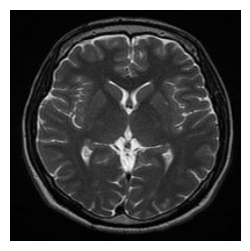

In [ ]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model_resnet50.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG19

base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))  # Use 224x224 input shape

# Freeze the convolutional base to avoid retraining it
for layer in base_model_vgg19.layers:
    layer.trainable = False

# Build the model
model_vgg19 = Sequential([
    Input(shape=(256, 256, 3)),
    base_model_vgg19,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg19.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,414,276 (108.39 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Fit the ResNet50 model
VGG_Model_history = model_vgg19.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=25,
    batch_size=32,
    verbose=1
)

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 815s 9s/step - accuracy: 0.4144 - loss: 1.5446 - val_accuracy: 0.7262 - val_loss: 0.7627
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 811s 9s/step - accuracy: 0.6410 - loss: 0.8361 - val_accuracy: 0.7622 - val_loss: 0.6517
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 809s 9s/step - accuracy: 0.7369 - loss: 0.6774 - val_accuracy: 0.7824 - val_loss: 0.6091
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 814s 9s/step - accuracy: 0.7679 - loss: 0.6100 - val_accuracy: 0.8156 - val_loss: 0.5376
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 814s 9s/step - accuracy: 0.8078 - loss: 0.5490 - val_accuracy: 0.7853 - val_loss: 0.5622
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 860s 9s/step - accuracy: 0.8170 - loss: 0.5016 - val_accuracy: 0.8501 - val_loss: 0.4695
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 810s 9s/step - accuracy: 0.8485 - loss: 0.4477 - val_accuracy: 0.7968 - val_loss: 0.4971
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 809s 9s/step - accuracy: 0.8262 - loss: 0.4630 - val_accuracy: 0.8300 - v

87/87 ━━━━━━━━━━━━━━━━━━━━ 631s 7s/step


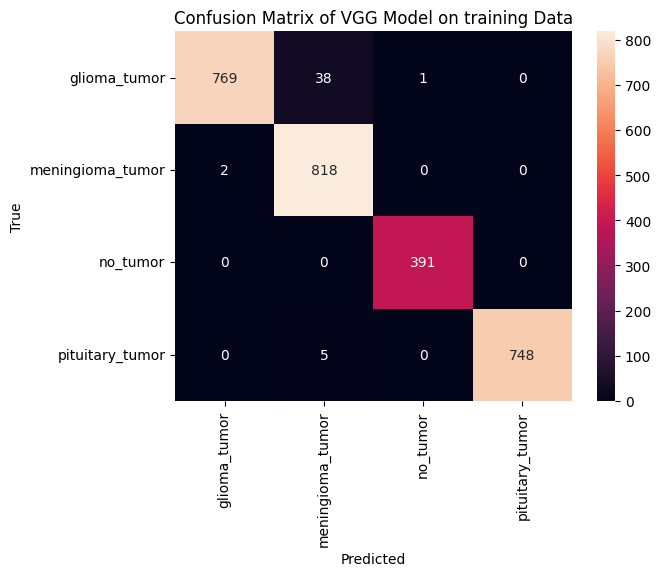

In [ ]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model_vgg19.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of VGG Model on training Data')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step


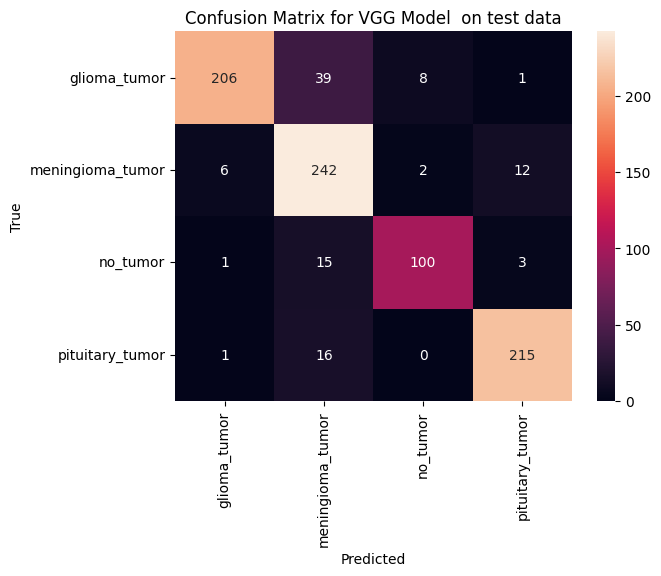

In [ ]:

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model_vgg19.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for VGG Model  on test data')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.81      0.88       254
meningioma_tumor       0.78      0.92      0.84       262
        no_tumor       0.91      0.84      0.87       119
 pituitary_tumor       0.93      0.93      0.93       232

        accuracy                           0.88       867
       macro avg       0.89      0.88      0.88       867
    weighted avg       0.89      0.88      0.88       867



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 71.10%



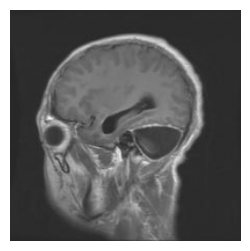

In [ ]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model_vgg19.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()